#Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Cell 2: imports
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Optional: if running in Colab and data is on Drive, uncomment and mount:
# from google.colab import drive
# drive.mount('/content/drive')


In [4]:
# Cell 3: dataset file paths - update if needed
X_path = '/content/drive/MyDrive/Dataset/LDC_NS_2D/128x128/skelneton_lid_driven_cavity_X.npz'
Y_path = '/content/drive/MyDrive/Dataset/LDC_NS_2D/128x128/skelneton_lid_driven_cavity_Y.npz'

# load files (this will raise if paths are wrong)
X_file = np.load(X_path)
Y_file = np.load(Y_path)

print("Keys in X.npz:", X_file.files)
print("Keys in Y.npz:", Y_file.files)

# Main arrays are usually stored under 'data' as in your original file
X = X_file['data']  # expect shape (N, C, H, W)
Y = Y_file['data']  # expect shape (N, C, H, W)

print("X.shape:", X.shape, "dtype:", X.dtype)
print("Y.shape:", Y.shape, "dtype:", Y.dtype)


Keys in X.npz: ['data']
Keys in Y.npz: ['data']
X.shape: (1000, 3, 128, 128) dtype: float64
Y.shape: (1000, 4, 128, 128) dtype: float64


## Inspect Data

In [8]:
import numpy as np
# Load
X = np.load(X_path)['data']   # shape (1000, 3, 128, 128)
Y = np.load(Y_path)['data']   # shape (1000, 4, 128, 128)
print("X shape:", X.shape)
print("Y shape:", Y.shape)
# Function to inspect channels
def inspect_tensor(name, arr):
    print(f"\n===== Inspecting {name} =====")
    num_samples, num_channels, H, W = arr.shape
    for ch in range(num_channels):
        print(f"\n--- {name} Channel {ch} ---")
        # Print first 1–2 rows (first sample only)
        print("First row:\n", arr[0, ch, 0, :10])       # first 10 elements
        print("Second row:\n", arr[0, ch, 1, :10])
        # Statistics
        print("Min:", arr[0, ch].min())
        print("Max:", arr[0, ch].max())
        # Unique values (limit output)
        unique_vals = np.unique(arr[0, ch])
        if len(unique_vals) > 20:
            print("Unique values (first 20):", unique_vals[:20], "...")
            print("Total unique:", len(unique_vals))
        else:
            print("Unique values:", unique_vals)
# Inspect X and Y
inspect_tensor("X", X)
inspect_tensor("Y", Y)

X shape: (1000, 3, 128, 128)
Y shape: (1000, 4, 128, 128)

===== Inspecting X =====

--- X Channel 0 ---
First row:
 [17. 17. 17. 17. 17. 17. 17. 17. 17. 17.]
Second row:
 [17. 17. 17. 17. 17. 17. 17. 17. 17. 17.]
Min: 17.0
Max: 17.0
Unique values: [17.]

--- X Channel 1 ---
First row:
 [0.80569674 0.79567441 0.78583616 0.77510456 0.76386675 0.75278679
 0.74187173 0.73112898 0.72056623 0.71019153]
Second row:
 [0.79380948 0.78363513 0.7736438  0.76384267 0.75296991 0.74172718
 0.73064693 0.71973665 0.70900421 0.69845778]
Min: -0.08427540337369896
Max: 1.2986497188479162
Unique values (first 20): [-0.0842754  -0.08347168 -0.082052   -0.08071165 -0.07677767 -0.07448745
 -0.07327042 -0.07273482 -0.07259127 -0.07049837 -0.06927654 -0.06915889
 -0.06892008 -0.06866112 -0.06843876 -0.06814305 -0.06768889 -0.06687022
 -0.06648899 -0.06639642] ...
Total unique: 16247

--- X Channel 2 ---
First row:
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
Second row:
 [255. 255. 255. 255. 255. 255.

Dataset X (input) : Channel 0 : RE, Channel 1 : SDF, Channel 2 : Mask

Dataset Y (input) : Channel 0 : u (Horizontal velocity), Channel 1 : v (vertical velocity), Channel 2 : p (pressure), Channel 3 : unknown

## Creating LDC dataset points
generating coordinate grid points to be fed into trunk network

In [27]:
# Cell 4: Dataset (no normalization) and collate function
class LDCDataset(Dataset):
    def __init__(self, X, Y):
        """
        X: numpy array (N, C_in, H, W)
        Y: numpy array (N, C_out, H, W)
        No normalization applied.
        """
        assert X.shape[0] == Y.shape[0], "X and Y must have same number of samples"
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

        # Build coordinate grid (shared across samples)
        _, _, H, W = self.X.shape
        yy, xx = torch.meshgrid(
            torch.linspace(0.0, 1.0, H, dtype=torch.float32),
            torch.linspace(0.0, 1.0, W, dtype=torch.float32),
            indexing='ij'
        )
        # coords shape: (H*W, 2) with columns (x, y)
        self.coords = torch.stack([xx, yy], dim=-1).reshape(-1, 2)

        self.H = H
        self.W = W

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # return X_sample, coords (shared), Y_sample
        return self.X[idx], self.coords, self.Y[idx]

def ldc_collate_fn(batch):
    """
    Custom collate: stack X and Y, but keep coords from first item (same for all)
    """
    Xs = [item[0] for item in batch]
    coords = batch[0][1]   # same coords for all samples in dataset
    Ys = [item[2] for item in batch]
    X_batch = torch.stack(Xs, dim=0)
    Y_batch = torch.stack(Ys, dim=0)
    return X_batch, coords, Y_batch


In [28]:
# Cell 5: Model definitions

class BranchNet(nn.Module):
    def __init__(self, in_channels=3, latent_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4)),
            nn.Flatten(),
            nn.Linear(128*4*4, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim)
        )

    def forward(self, x):
        # x: (B, in_channels, H, W)
        return self.net(x)  # (B, latent_dim)

class TrunkNet(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, coords):
        # coords: (N_coords, 2)
        return self.net(coords)  # (N_coords, latent_dim)

class DeepONet(nn.Module):
    def __init__(self, in_channels=3, latent_dim=256, out_channels=4, H=128, W=128):
        """
        out_channels: number of output channels in Y (e.g., 3 for u,v,p)
        H,W: grid height and width (needed for reshape)
        """
        super().__init__()
        self.branch = BranchNet(in_channels, latent_dim)
        self.trunk = TrunkNet(latent_dim)
        self.final = nn.Linear(latent_dim, out_channels)
        self.H = H
        self.W = W

    def forward(self, x, coords):
        """
        x: (B, in_channels, H, W)
        coords: (N_coords, 2)
        returns: (B, out_channels, H, W)
        """
        B = x.size(0)
        b = self.branch(x)          # (B, D)
        t = self.trunk(coords)      # (N_coords, D)

        # Combine via outer product / einsum: produce (B, N_coords, D)
        fused = torch.einsum('bd,nd->bnd', b, t)  # (B, N_coords, D)

        # Map latent_dim -> out_channels for each (B, N_coords)
        out = self.final(fused)  # (B, N_coords, out_channels)

        # reshape to (B, out_channels, H, W)
        out = out.permute(0, 2, 1).reshape(B, -1, self.H, self.W)
        return out


In [29]:
# Cell 6: instantiate dataset, dataloader, model, optimizer
dataset = LDCDataset(X, Y)
batch_size = 4

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=ldc_collate_fn)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

in_channels = X.shape[1]
out_channels = Y.shape[1]
H, W = dataset.H, dataset.W

model = DeepONet(in_channels=in_channels, latent_dim=256, out_channels=out_channels, H=H, W=W).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()


Using device: cuda


In [12]:
# Cell 7: training loop
EPOCHS = 125  # set smaller for testing; increase as needed
print_every = 25

# Move coords tensor once to device (coords is shared)
coords_device = dataset.coords.to(device)

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    iters = 0
    for x_batch, coords, y_batch in loader:
        # x_batch: (B, C_in, H, W)
        # coords: (N_coords, 2)  -> from collate_fn it's already a single tensor
        # y_batch: (B, C_out, H, W)

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # coords_device is precomputed above; ensure shapes match
        pred = model(x_batch, coords_device)

        loss = criterion(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        iters += 1

    avg_loss = running_loss / max(1, iters)
    if epoch % print_every == 0 or epoch == 1:
        print(f"Epoch {epoch}/{EPOCHS}  Avg Loss: {avg_loss:.6e}")


Epoch 1/125  Avg Loss: 7.094167e-03
Epoch 25/125  Avg Loss: 6.877591e-03
Epoch 50/125  Avg Loss: 6.332660e-03
Epoch 75/125  Avg Loss: 5.529903e-03
Epoch 100/125  Avg Loss: 5.674657e-03
Epoch 125/125  Avg Loss: 5.901799e-03


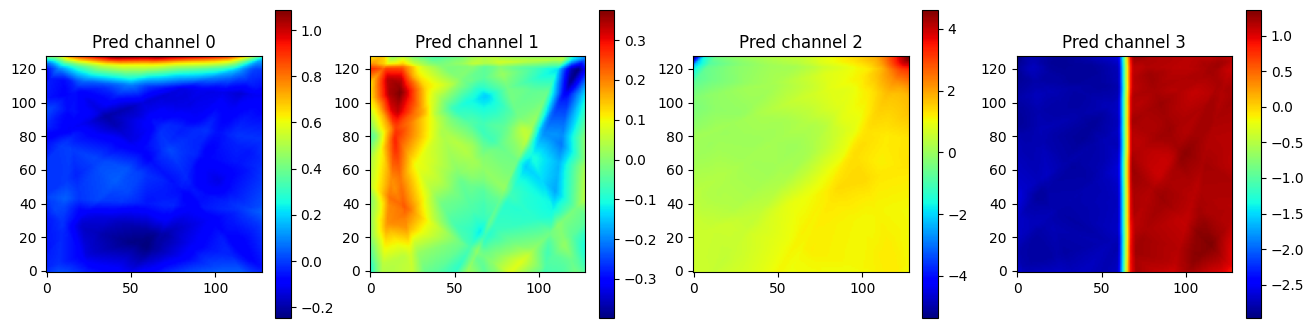

In [13]:
# Cell 9: inference on a single sample and quick imshow for channels
model.eval()
sample_idx = 0
x_sample, coords, y_true = dataset[sample_idx]
x_in = x_sample.unsqueeze(0).to(device)   # (1, C_in, H, W)
coords_device = dataset.coords.to(device)

with torch.no_grad():
    pred = model(x_in, coords_device)  # (1, C_out, H, W)
pred = pred[0].cpu()    # (C_out, H, W)
y_true = y_true.cpu()   # (C_out, H, W)

# Plot channels side-by-side
C = pred.shape[0]
plt.figure(figsize=(4*C,4))
for i in range(C):
    plt.subplot(1,C,i+1)
    plt.title(f'Pred channel {i}')
    plt.imshow(pred[i], cmap='jet', origin='lower')
    plt.colorbar()
plt.show()


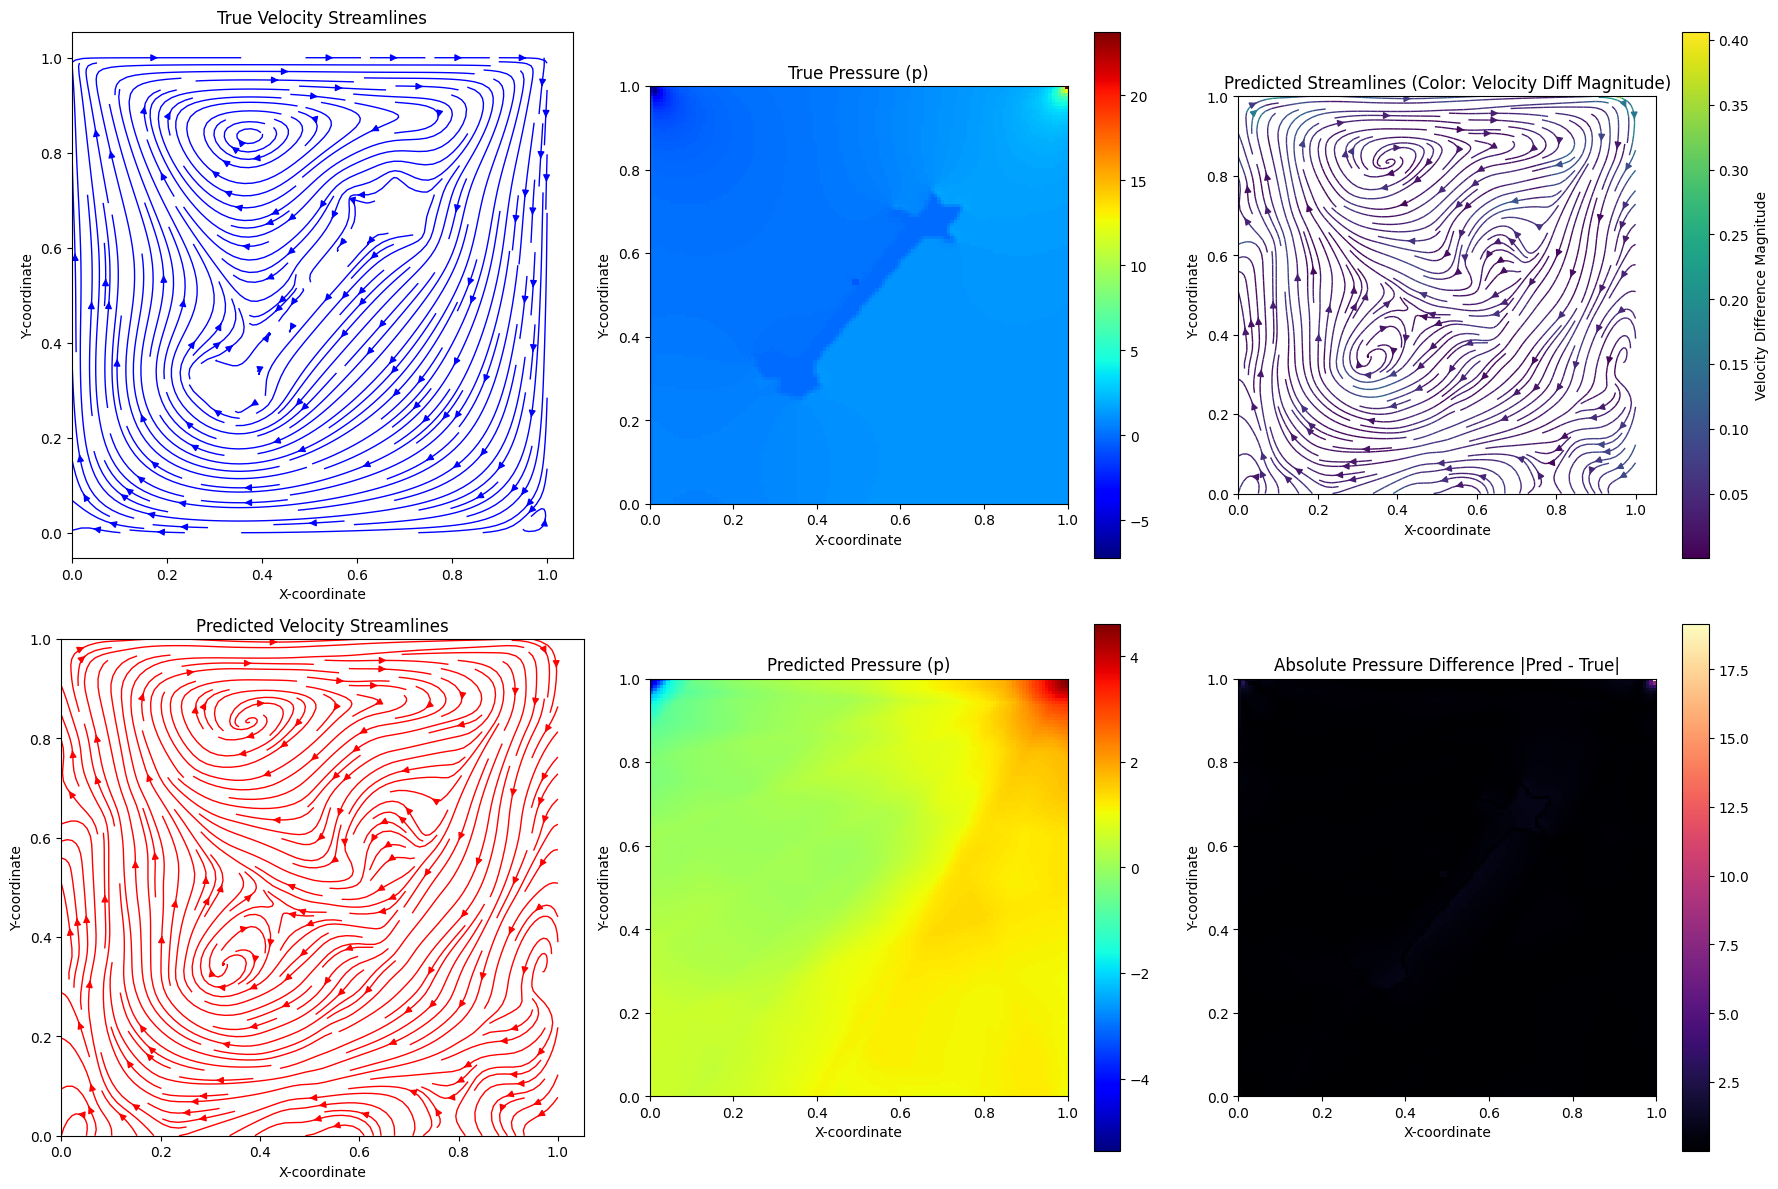

In [14]:
# Cell 10: detailed visualization - streamlines + pressure + differences
# Use the same approach as your original code, but ensure shapes are correct.

# Get coords on CPU and reshape to grid
coords = dataset.coords  # (N_coords, 2)
H, W = dataset.H, dataset.W
xx = coords[:,0].reshape(H, W).cpu().numpy()
yy = coords[:,1].reshape(H, W).cpu().numpy()

# True and predicted
u_true = y_true[0].numpy()
v_true = y_true[1].numpy()
p_true = y_true[2].numpy()

u_pred = pred[0].numpy()
v_pred = pred[1].numpy()
p_pred = pred[2].numpy()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# True Streamlines (u, v)
axes[0, 0].streamplot(xx, yy, u_true, v_true, density=2, color='blue', linewidth=1)
axes[0, 0].set_title('True Velocity Streamlines')
axes[0, 0].set_xlabel('X-coordinate')
axes[0, 0].set_ylabel('Y-coordinate')
axes[0, 0].set_aspect('equal')

# True Pressure (p)
im1 = axes[0, 1].imshow(p_true, cmap='jet', origin='lower', extent=[xx.min(), xx.max(), yy.min(), yy.max()])
axes[0, 1].set_title('True Pressure (p)')
axes[0, 1].set_xlabel('X-coordinate')
axes[0, 1].set_ylabel('Y-coordinate')
fig.colorbar(im1, ax=axes[0, 1])

# Predicted Streamlines (color-coded by diff magnitude)
diff_u = u_pred - u_true
diff_v = v_pred - v_true
diff_magnitude = np.sqrt(diff_u**2 + diff_v**2)

# streamplot with color (matplotlib's streamplot accepts color array flattened)
strm = axes[0, 2].streamplot(xx, yy, u_pred, v_pred, density=2, color=diff_magnitude, cmap='viridis', linewidth=1)
axes[0, 2].set_title('Predicted Streamlines (Color: Velocity Diff Magnitude)')
axes[0, 2].set_xlabel('X-coordinate')
axes[0, 2].set_ylabel('Y-coordinate')
axes[0, 2].set_aspect('equal')
# Add colorbar for streamplot using the LineCollection from the returned object
fig.colorbar(strm.lines, ax=axes[0, 2], label='Velocity Difference Magnitude')

# Predicted streamlines (red)
axes[1, 0].streamplot(xx, yy, u_pred, v_pred, density=2, color='red', linewidth=1)
axes[1, 0].set_title('Predicted Velocity Streamlines')
axes[1, 0].set_xlabel('X-coordinate')
axes[1, 0].set_ylabel('Y-coordinate')
axes[1, 0].set_aspect('equal')

# Predicted Pressure (p)
im2 = axes[1, 1].imshow(p_pred, cmap='jet', origin='lower', extent=[xx.min(), xx.max(), yy.min(), yy.max()])
axes[1, 1].set_title('Predicted Pressure (p)')
axes[1, 1].set_xlabel('X-coordinate')
axes[1, 1].set_ylabel('Y-coordinate')
fig.colorbar(im2, ax=axes[1, 1])

# Absolute Pressure Difference
im4 = axes[1, 2].imshow(np.abs(p_pred - p_true), cmap='magma', origin='lower', extent=[xx.min(), xx.max(), yy.min(), yy.max()])
axes[1, 2].set_title('Absolute Pressure Difference |Pred - True|')
axes[1, 2].set_xlabel('X-coordinate')
axes[1, 2].set_ylabel('Y-coordinate')
fig.colorbar(im4, ax=axes[1, 2])

plt.tight_layout()
plt.show()


## Conclusion

Despite achieving a low average loss, the predicted output visualization is still unsatisfactory.